In [88]:
#Q1

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))


def stem_rmv_punc_nolem(doc):
    return (word for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

#Download dataset
dataset = fetch_20newsgroups(subset='all', categories = categories, shuffle = True, random_state = 0, remove=('headers','footers')) 

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc_nolem, stop_words='english')

X_counts = count_vect.fit_transform(dataset.data)
X_tfidf = tfidf_transformer.fit_transform(X_counts)

print("X_tfidf shape: ", X_tfidf.shape)

X_tfidf shape:  (7882, 21909)


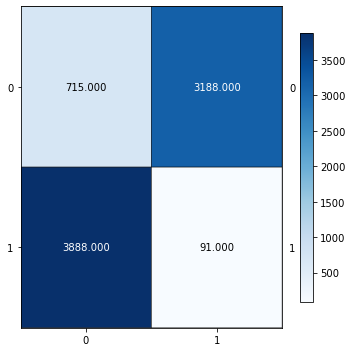

In [89]:
#Q2
#Get labels to verify k means accuracy

from sklearn.cluster import KMeans
from plotmat import plot_mat
from sklearn.metrics.cluster import contingency_matrix

dataset_targets_bin = dataset.target.copy()
for i in range(len(dataset_targets_bin)):
    if dataset.target[i] in [0,1,2,3]:
        dataset_targets_bin[i] = 0
    else:
        dataset_targets_bin[i] = 1

kmeans_clf = KMeans(n_clusters=2, max_iter=1500, random_state=0, n_init=50)
kmeans_clf.fit(X_tfidf)
km_cont_mat = contingency_matrix(dataset_targets_bin, kmeans_clf.labels_)

plot_mat(km_cont_mat, size=(5,5))
        

In [90]:
#Q3

from sklearn import metrics
print("Homogeneity score: ", metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_))
print("Completeness score: ", metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_))
print("V_measure score: ", metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_))
print("Adjusted Mutual Information Score: ", metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_))


Homogeneity score:  0.5600025412974119
Completeness score:  0.5716557539454379
V_measure score:  0.5657691483417876
Adjusted Rand Index score:  0.6327475635535726
Adjusted Mutual Information Score:  0.5657289846874574


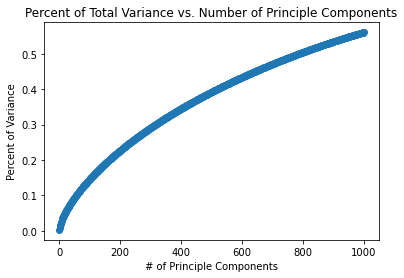

In [91]:
#Q4

from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np

variances = []
r_vals = np.arange(1, 1001)

trunc_svd = TruncatedSVD(n_components=1000, random_state=0)
X_svd = trunc_svd.fit_transform(X_tfidf)

variances = trunc_svd.explained_variance_ratio_

plt.scatter(r_vals, np.cumsum(variances))
plt.xlabel("# of Principle Components")
plt.ylabel("Percent of Variance")
plt.title("Percent of Total Variance vs. Number of Principle Components")
plt.show()

In [92]:

#Q5
r_vals_5 = [1,2,3,5,10,20,50,100,300]
metric_scores_svd = []
metric_scores_nmf = []

for r in r_vals_5:
    nmf_model = NMF(n_components=r, init='random', random_state=0, max_iter=1000)
    nmf_red = nmf_model.fit_transform(X_tfidf)
    svd_red = X_svd[:,:r]
    
    kmeans_clf.fit(nmf_red)
    metric_scores_nmf.append((metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_)))
    kmeans_clf.fit(svd_red)
    metric_scores_svd.append((metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_)))

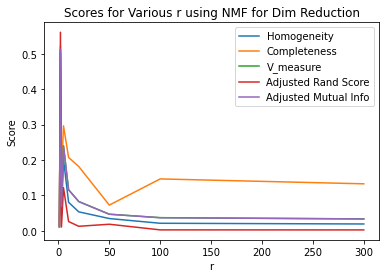

In [93]:
plt.plot(r_vals_5, metric_scores_nmf)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("r")
plt.ylabel("Score")
plt.title("Scores for Various r using NMF for Dim Reduction")
plt.show()

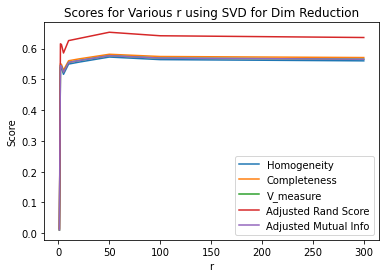

In [94]:
plt.plot(r_vals_5, metric_scores_svd)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("r")
plt.ylabel("Score")
plt.title("Scores for Various r using SVD for Dim Reduction")
plt.show()

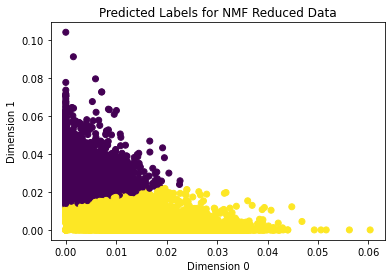

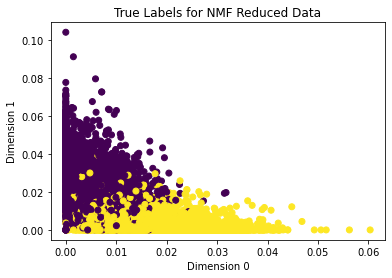

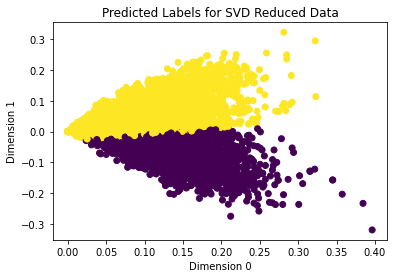

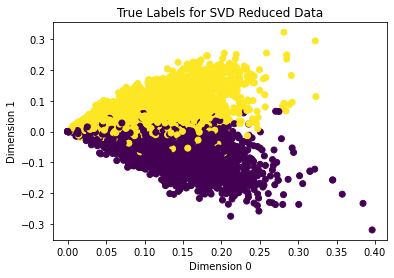

In [95]:
#Q7

nmf_best_k = 2
svd_best_k = 50

trunc_svd_q3 = TruncatedSVD(n_components=2, random_state=0)

nmf_model = NMF(n_components=nmf_best_k, init='random', random_state=0, max_iter=1000)
nmf_red = nmf_model.fit_transform(X_tfidf)
nmf_red_SVD = nmf_red#trunc_svd_q3.fit_transform(nmf_red)
kmeans_clf.fit(nmf_red_SVD)
nmf_labels = kmeans_clf.labels_

svd_red = X_svd[:,:svd_best_k]
svd_red_SVD = trunc_svd_q3.fit_transform(svd_red)
kmeans_clf.fit(svd_red_SVD)
svd_labels = kmeans_clf.labels_

plt.scatter(nmf_red_SVD[:,0], nmf_red_SVD[:,1], c=nmf_labels)
plt.title("Predicted Labels for NMF Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(nmf_red_SVD[:,0], nmf_red_SVD[:,1], c=dataset_targets_bin)
plt.title("True Labels for NMF Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(svd_red_SVD[:,0], svd_red_SVD[:,1], c=svd_labels)
plt.title("Predicted Labels for SVD Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(svd_red_SVD[:,0], svd_red_SVD[:,1], c=dataset_targets_bin)
plt.title("True Labels for SVD Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()




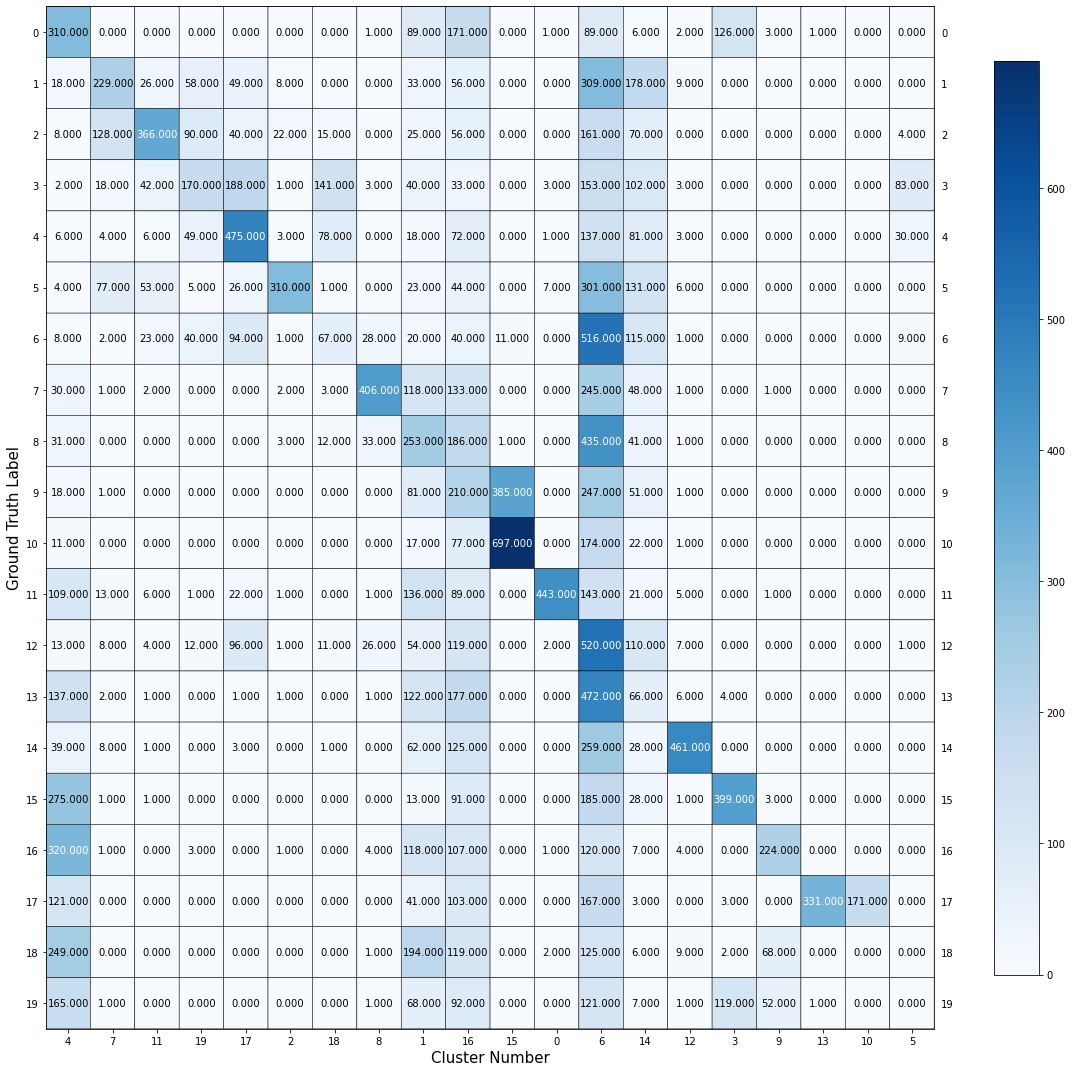

Homogeneity score:  0.31630458145750995
Completeness score:  0.3682552023183464
V_measure score:  0.3403086491478565
Adjusted Rand Index score:  0.10379799750286293
Adjusted Mutual Information Score:  0.3380068278889245


In [96]:
#Q9
#get all 20 categories this time
full_dataset = fetch_20newsgroups(subset='all', shuffle = True, random_state = 0, remove=('headers','footers'))
full_count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc_nolem, stop_words='english')
full_X_counts = full_count_vect.fit_transform(full_dataset.data)
full_X_tfidf = tfidf_transformer.fit_transform(full_X_counts)

#using SVD with r=50 - best results from earlier
full_trunc_svd = TruncatedSVD(n_components=1000, random_state=0)
full_X_svd = full_trunc_svd.fit_transform(full_X_tfidf)
full_svd_red = full_X_svd[:,:50]

#k-means w/20 clusters
full_kmeans_clf = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
full_kmeans_clf.fit(full_svd_red)

#metrics!
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

cm = contingency_matrix(full_dataset.target, full_kmeans_clf.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15), xlabel="Cluster Number", ylabel="Ground Truth Label")

print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, full_kmeans_clf.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, full_kmeans_clf.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, full_kmeans_clf.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, full_kmeans_clf.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, full_kmeans_clf.labels_))


In [97]:
#Q10

r_vals = [2,5,10,30,50,100]

for i in r_vals:
    nmf_KL = NMF(n_components=i, init='random', random_state=0, max_iter=1000, beta_loss = "kullback-leibler", solver='mu')
    nmf_red_KL = nmf_KL.fit_transform(full_X_tfidf)
    kmeans_clf_KL = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_KL.fit(nmf_red_KL)
    print()
    print("r = " + str(i))
    print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("Completeness score: ", metrics.completeness_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("V_measure score: ", metrics.v_measure_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_KL.labels_))

    


r = 2
Homogeneity score:  0.19676527887644293
Completeness score:  0.2136834606423116
V_measure score:  0.2048756966527202
Adjusted Rand Index score:  0.0604569445452653
Adjusted Mutual Information Score:  0.20217480540664073

r = 5
Homogeneity score:  0.35641214262487414
Completeness score:  0.38144347646289517
V_measure score:  0.3685032226345344
Adjusted Rand Index score:  0.15027690007707672
Adjusted Mutual Information Score:  0.3663744867466823

r = 10
Homogeneity score:  0.37714629232162333
Completeness score:  0.3900505160910544
V_measure score:  0.3834898799077068
Adjusted Rand Index score:  0.18833101982676798
Adjusted Mutual Information Score:  0.38146535004967785

r = 30
Homogeneity score:  0.36866650441353743
Completeness score:  0.42527782891459665
V_measure score:  0.39495386265506316
Adjusted Rand Index score:  0.12617792572471453
Adjusted Mutual Information Score:  0.3928569966801935

r = 50
Homogeneity score:  0.30640759897200137
Completeness score:  0.478739722239545

In [153]:
#Q11 

import umap

n_vals = [2,5,10,50,100,200,300,500,700,1000]
metric_scores_euc = []
metric_scores_cos = []


for i in n_vals:
    print("working on reducing for n = " + str(i))
    reducer_euc = umap.UMAP(n_components=i, init='random', metric="euclidean")
    embedding_euc = reducer_euc.fit_transform(full_X_tfidf)
    reducer_cos = umap.UMAP(n_components=i, init='random', metric="cosine")
    embedding_cos = reducer_cos.fit_transform(full_X_tfidf)
    
    print("working on kmeans for n = " + str(i))
    kmeans_clf_euc = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_euc.fit(embedding_euc)
    kmeans_clf_cos = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_cos.fit(embedding_cos)
    
    metric_scores_euc.append((metrics.homogeneity_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.completeness_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.v_measure_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_euc.labels_)))
    
    metric_scores_cos.append((metrics.homogeneity_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.completeness_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.v_measure_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_cos.labels_)))

    
plt.plot(n_vals, metric_scores_euc)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Euclidean Metric")
plt.show()

plt.plot(n_vals, metric_scores_cos)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Cosine Metric")
plt.show()

working on reducing for n = 2


KeyboardInterrupt: 

Performance of UMAP reduced data for n_components=5

Euclidean metric
Homogeneity score:  0.008428056566878686
Completeness score:  0.008490790660743977
V_measure score:  0.008459307306639803
Adjusted Rand Index score:  0.0014762057832842827
Adjusted Mutual Information Score:  0.00524781170211466

Cosine metric
Homogeneity score:  0.5347926404764849
Completeness score:  0.5549487009354954
V_measure score:  0.5446842655666289
Adjusted Rand Index score:  0.4167210932677909
Adjusted Mutual Information Score:  0.5431756896373161


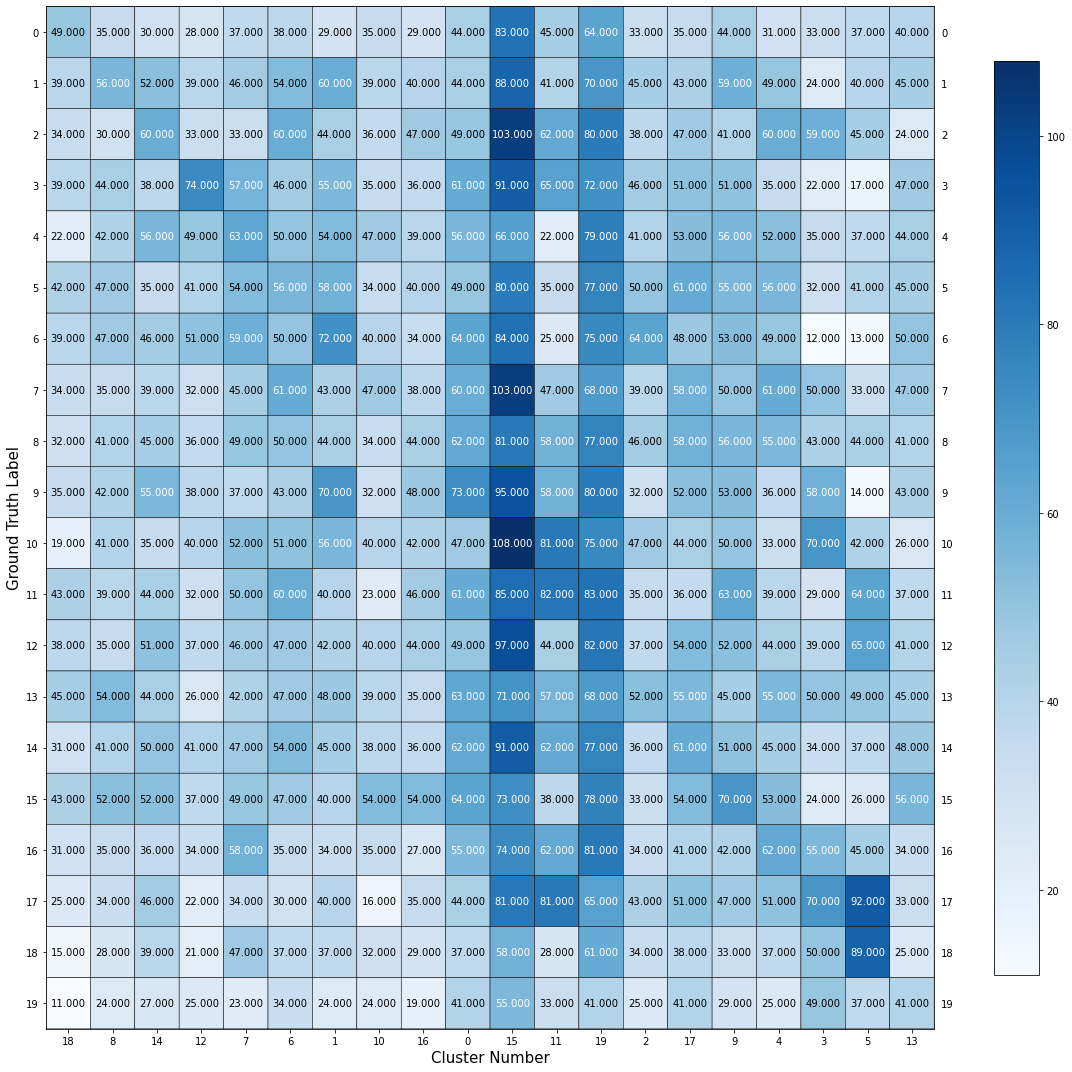

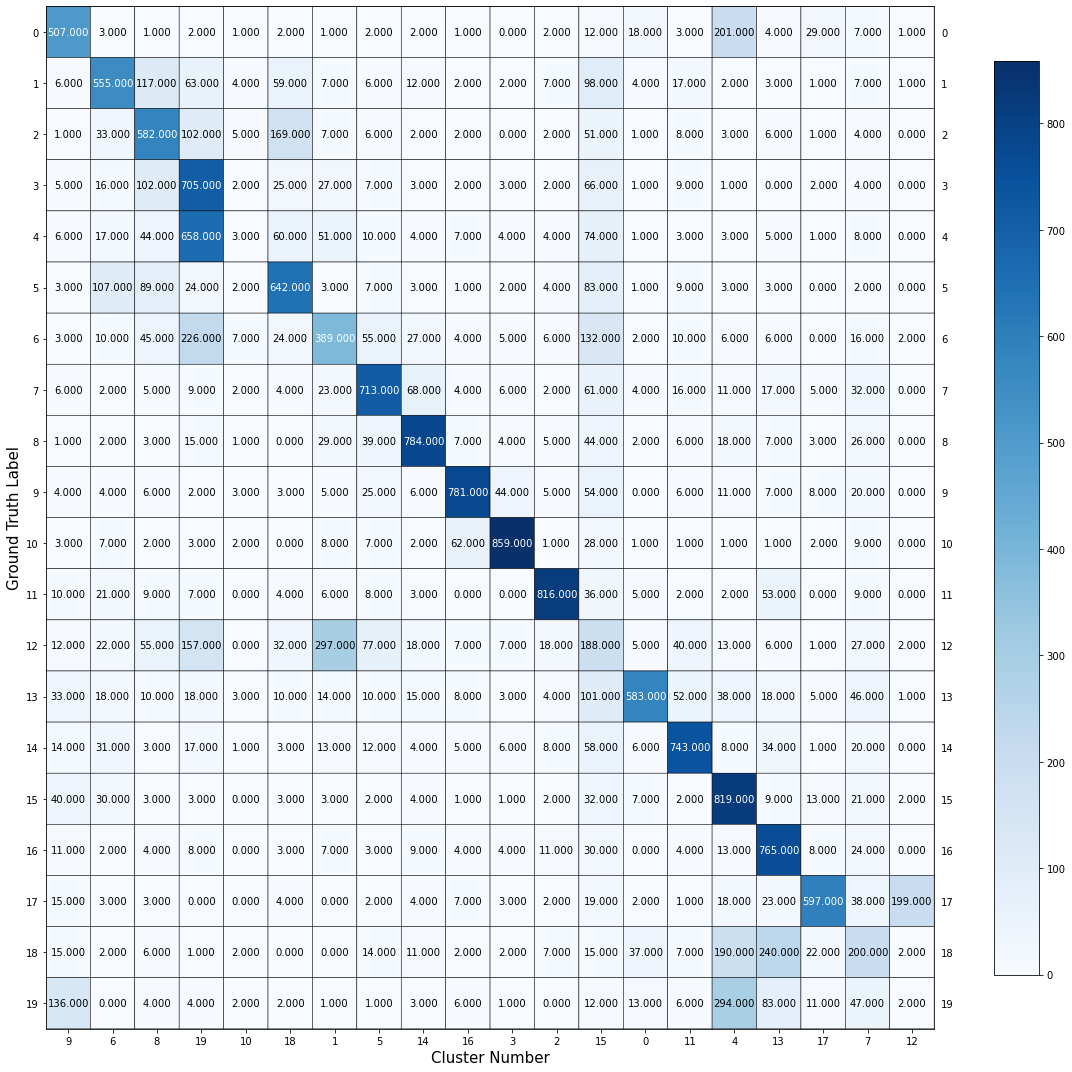

In [143]:
#Q12
#Best n_components = 5 for both euclidean and cosine metrics

reducer_euc = umap.UMAP(n_components=5, init='random', metric="euclidean", random_state=42)
embedding_euc = reducer_euc.fit_transform(full_X_tfidf)
reducer_cos = umap.UMAP(n_components=5, init='random', metric="cosine", random_state=42)
embedding_cos = reducer_cos.fit_transform(full_X_tfidf)

kmeans_clf_euc = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
kmeans_clf_euc.fit(embedding_euc)
kmeans_clf_cos = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
kmeans_clf_cos.fit(embedding_cos)

print("Performance of UMAP reduced data for n_components=5")
print()
print("Euclidean metric")
print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, kmeans_clf_euc.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, kmeans_clf_euc.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, kmeans_clf_euc.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_euc.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_euc.labels_))

print()
print("Cosine metric")
print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, kmeans_clf_cos.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, kmeans_clf_cos.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, kmeans_clf_cos.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_cos.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_cos.labels_))

cm = contingency_matrix(full_dataset.target, kmeans_clf_euc.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15), xlabel="Cluster Number", ylabel="Ground Truth Label")

cm = contingency_matrix(full_dataset.target, kmeans_clf_cos.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15), xlabel="Cluster Number", ylabel="Ground Truth Label")

In [142]:
#Q13
#using same umap parameters as above

from sklearn.cluster import AgglomerativeClustering

umap_best_n = 5
umap_best_metric = 'cosine'

umap_reducer = umap.UMAP(n_components=umap_best_n, init='random', metric=umap_best_metric, random_state=42)
    
red_umap = umap_reducer.fit_transform(full_X_tfidf)


agg_clust_ward = AgglomerativeClustering(n_clusters=20, linkage='ward')
agg_clust_single = AgglomerativeClustering(n_clusters=20, linkage='single')

agg_clust_ward.fit(red_umap)
agg_clust_single.fit(red_umap)

print("Ward Linkage Scores")
print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, agg_clust_ward.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, agg_clust_ward.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, agg_clust_ward.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, agg_clust_ward.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, agg_clust_ward.labels_))

print()
print("Single Linkage Scores")
print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, agg_clust_single.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, agg_clust_single.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, agg_clust_single.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, agg_clust_single.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, agg_clust_single.labels_))


Ward Linkage Scores
Homogeneity score:  0.524473300498607
Completeness score:  0.5479912976714623
V_measure score:  0.53597443687123
Adjusted Rand Index score:  0.3940501791969448
Adjusted Mutual Information Score:  0.5344316766896055

Single Linkage Scores
Homogeneity score:  0.022917457355135236
Completeness score:  0.3464156710750703
V_measure score:  0.04299081646294147
Adjusted Rand Index score:  0.00046761208355549543
Adjusted Mutual Information Score:  0.03748616963750802


In [140]:
#Q14 with more hyperparams

eps_vals = [.01,.05,.1,.3,.5,.7,.9,1]
metric_types = [ 'euclidean', 'manhattan', 'cosine']
min_samples = [10, 20, 50, 70, 100]

db_max_score = -100
hdb_max_score = -100

for eps in eps_vals:
    for metric_t in metric_types:
        for min_samp in min_samples:
            print("Current Iteration: eps={:f}, metric={:s}, min_samples={:d}".format(eps, metric_t, min_samp))
            DBSCAN_clust = DBSCAN(min_samples=min_samp, metric=metric_t, eps=eps)
            
            #HDB does not support cosine metric
            if(metric_t != 'cosine'):
                HDBSCAN_clust = HDBSCAN(min_cluster_size=100, min_samples=min_samp, cluster_selection_epsilon=eps)

            DBSCAN_clust.fit(red_umap)
            HDBSCAN_clust.fit(red_umap)
            
            homog_score = metrics.homogeneity_score(full_dataset.target, DBSCAN_clust.labels_)
            comp_score = metrics.completeness_score(full_dataset.target, DBSCAN_clust.labels_)
            v_score = metrics.v_measure_score(full_dataset.target, DBSCAN_clust.labels_)
            rand_score = metrics.adjusted_rand_score(full_dataset.target, DBSCAN_clust.labels_)
            adj_mut_score = metrics.adjusted_mutual_info_score(full_dataset.target, DBSCAN_clust.labels_)
            
            score_avg = (homog_score + comp_score + v_score + rand_score + adj_mut_score)/5
            
            labels = DBSCAN_clust.labels_
            n_clust = len(set(labels)) - (1 if -1 in labels else 0)
            
            if score_avg > db_max_score:
                db_max_score = score_avg
                db_max_params = (eps, metric_t, min_samp)
                db_max_metrics = (homog_score, comp_score, v_score, rand_score, adj_mut_score)
            
            
            homog_score = metrics.homogeneity_score(full_dataset.target, HDBSCAN_clust.labels_)
            comp_score = metrics.completeness_score(full_dataset.target, HDBSCAN_clust.labels_)
            v_score = metrics.v_measure_score(full_dataset.target, HDBSCAN_clust.labels_)
            rand_score = metrics.adjusted_rand_score(full_dataset.target, HDBSCAN_clust.labels_)
            adj_mut_score = metrics.adjusted_mutual_info_score(full_dataset.target, HDBSCAN_clust.labels_)
            
            score_avg = (homog_score + comp_score + v_score + rand_score + adj_mut_score)/5

            labels = HDBSCAN_clust.labels_
            n_clust = len(set(labels)) - (1 if -1 in labels else 0)
            
            if metric_t != 'cosine' and score_avg > hdb_max_score:
                hdb_max_score = score_avg
                hdb_max_params = (eps, metric_t, min_samp)
                hdb_max_metrics = (homog_score, comp_score, v_score, rand_score, adj_mut_score)

print()
print("DBSCAN Best Parameters: eps={:f}, metric={:s}, min_samples={:d}".format(db_max_params[0], db_max_params[1], db_max_params[2]))
print()
print("Best DBSCAN Scores")
print("Homogeneity score: ", db_max_metrics[0])
print("Completeness score: ", db_max_metrics[1])
print("V_measure score: ", db_max_metrics[2])
print("Adjusted Rand Index score: ", db_max_metrics[3])
print("Adjusted Mutual Information Score: ", db_max_metrics[4])

print()
print("HDBSCAN Best Parameters: eps={:f}, metric={:s}, min_samples={:d}".format(hdb_max_params[0], hdb_max_params[1], hdb_max_params[2]))
print()
print("Best HDBSCAN Scores")
print("Homogeneity score: ", hdb_max_metrics[0])
print("Completeness score: ", hdb_max_metrics[1])
print("V_measure score: ", hdb_max_metrics[2])
print("Adjusted Rand Index score: ", hdb_max_metrics[3])
print("Adjusted Mutual Information Score: ", hdb_max_metrics[4])

Current Iteration: eps=0.010000, metric=euclidean, min_samples=10
Current Iteration: eps=0.010000, metric=euclidean, min_samples=20
Current Iteration: eps=0.010000, metric=euclidean, min_samples=50
Current Iteration: eps=0.010000, metric=euclidean, min_samples=70
Current Iteration: eps=0.010000, metric=euclidean, min_samples=100
Current Iteration: eps=0.010000, metric=manhattan, min_samples=10
Current Iteration: eps=0.010000, metric=manhattan, min_samples=20
Current Iteration: eps=0.010000, metric=manhattan, min_samples=50
Current Iteration: eps=0.010000, metric=manhattan, min_samples=70
Current Iteration: eps=0.010000, metric=manhattan, min_samples=100
Current Iteration: eps=0.010000, metric=cosine, min_samples=10
Current Iteration: eps=0.010000, metric=cosine, min_samples=20
Current Iteration: eps=0.010000, metric=cosine, min_samples=50
Current Iteration: eps=0.010000, metric=cosine, min_samples=70
Current Iteration: eps=0.010000, metric=cosine, min_samples=100
Current Iteration: eps

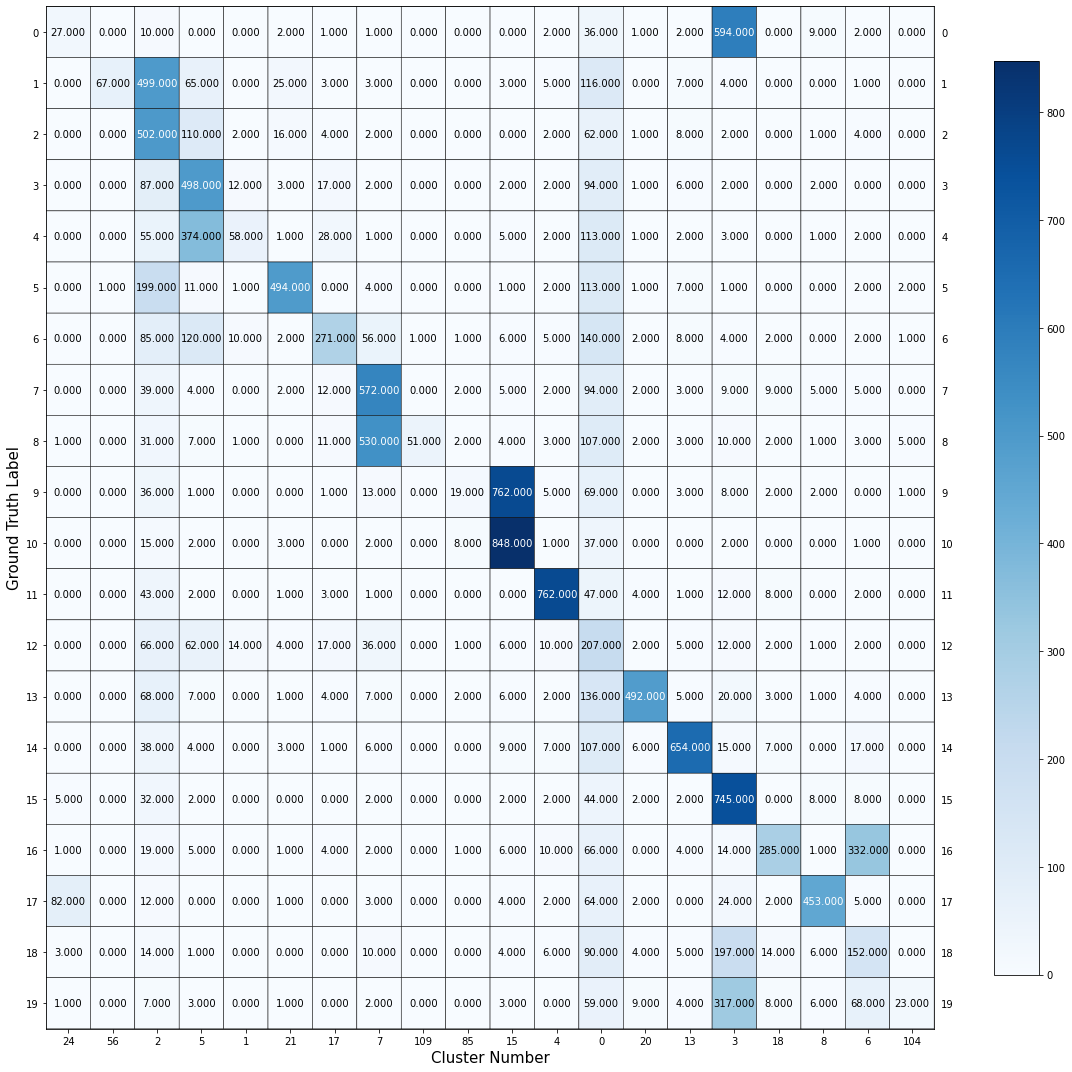

Estimated number of clusters:  168


In [141]:
# Q15

DBSCAN_clust = DBSCAN(min_samples=10, eps=0.5, metric='manhattan')
DBSCAN_clust.fit(red_umap)

cm = contingency_matrix(full_dataset.target, DBSCAN_clust.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15), xlabel="Cluster Number", ylabel="Ground Truth Label")

#when label is -1, DBSCAN thinks the point is noise - so it might estimate fewer clusters than we actually have!
labels = DBSCAN_clust.labels_
n_clust = len(set(labels)) - (1 if -1 in labels else 0)
print("Estimated number of clusters: ", n_clust)

In [126]:
#Q16

#get data and vectorize

#Using the larger training dataset
import pandas
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from plotmat import plot_mat
import numpy as np
import umap.umap_ as umap

bbc = pandas.read_csv('BBC_News_Train.csv')
categories = (bbc.Category.unique()).tolist()
targets = []
for i in bbc.Category:
    for j in range(0,len(categories)):
        if i == categories[j]:
            targets.append(j)
bbc['target'] = targets    

X_counts = count_vect.fit_transform(bbc.Text)
bbc_X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("bbc_X_tfidf shape: ", bbc_X_tfidf.shape)

bbc_X_tfidf shape:  (1490, 10197)


working on reducing for n = 2
working on kmeans for n = 2
working on reducing for n = 5
working on kmeans for n = 5
working on reducing for n = 10
working on kmeans for n = 10
working on reducing for n = 50
working on kmeans for n = 50
working on reducing for n = 100
working on kmeans for n = 100
working on reducing for n = 1000
working on kmeans for n = 1000


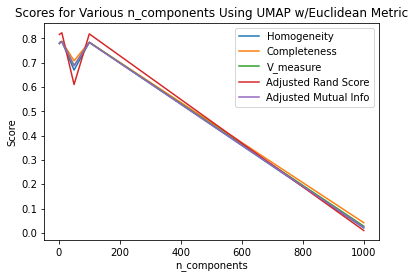

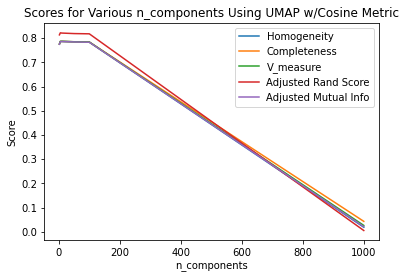

Best Kmeans Cos:  0.7930692963971817
Best Kmeans Euc:  0.7944233592691203

Best KMeans EUC Scores
Homogeneity score:  0.7874360944663693
Completeness score:  0.7874929063651126
V_measure score:  0.7874644993910623
Adjusted Rand Index score:  0.8229763601775667
Adjusted Mutual Information Score:  0.786746935945491
Best N_Components:  10


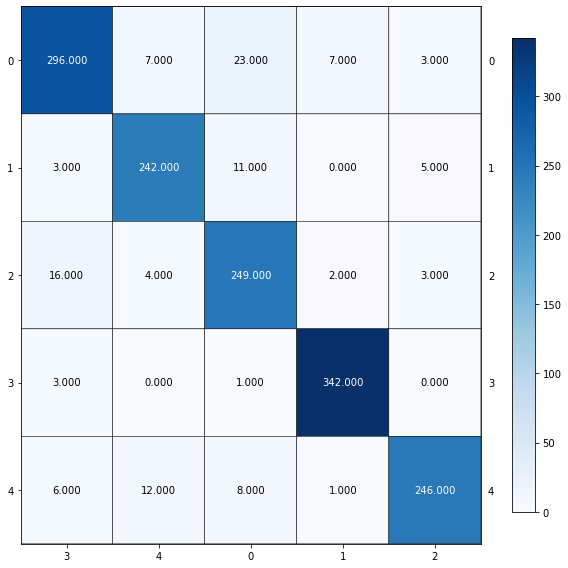


Best KMeans COS Scores
Homogeneity score:  0.7863911146778318
Completeness score:  0.7863053396249526
V_measure score:  0.7863482248123015
Adjusted Rand Index score:  0.8206748429226303
Adjusted Mutual Information Score:  0.785626959948192
Best N_Components:  10


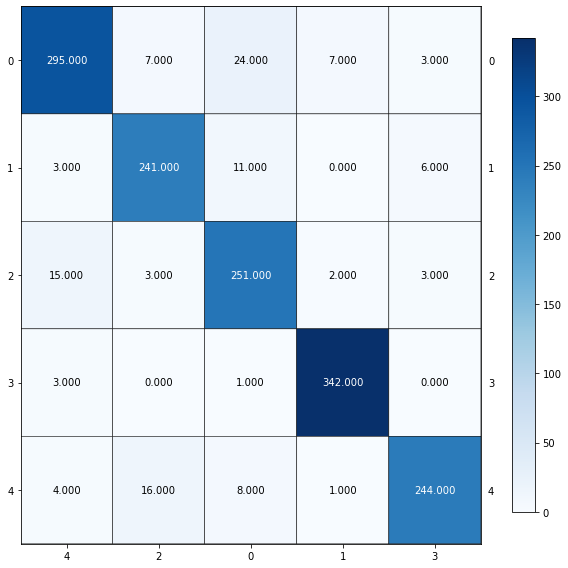

In [150]:
#Find best number of components and metric for UMAP reduction, using KMeans scores as evaluation

# Find best N and distance metric for KMeans

n_vals = [2,5,10,50,100,1000]
metric_scores_euc = []
metric_scores_cos = []


for i in n_vals:
    print("working on reducing for n = " + str(i))
    reducer_euc = umap.UMAP(n_components=i, init='random', metric="euclidean", random_state=0)
    embedding_euc = reducer_euc.fit_transform(bbc_X_tfidf)
    reducer_cos = umap.UMAP(n_components=i, init='random', metric="cosine", random_state=0)
    embedding_cos = reducer_cos.fit_transform(bbc_X_tfidf)
    
    col_mean = np.nanmean(embedding_cos, axis=0)
    inds = np.where(np.isnan(embedding_cos))
    embedding_cos[inds] = np.take(col_mean, inds[1])
    
    print("working on kmeans for n = " + str(i))
    kmeans_clf_euc = KMeans(n_clusters=5, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_euc.fit(embedding_euc)
    kmeans_clf_cos = KMeans(n_clusters=5, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_cos.fit(embedding_cos)
    
    metric_scores_euc.append((metrics.homogeneity_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.completeness_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.v_measure_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_rand_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_mutual_info_score(bbc.target, kmeans_clf_euc.labels_)))
    
    metric_scores_cos.append((metrics.homogeneity_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.completeness_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.v_measure_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_rand_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_mutual_info_score(bbc.target, kmeans_clf_cos.labels_)))


# Plot Metrics against n_components    
plt.plot(n_vals, metric_scores_euc)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Euclidean Metric")
plt.show()

plt.plot(n_vals, metric_scores_cos)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Cosine Metric")
plt.show()

# Find best values and print metrics

avs_Kmeans_cos = []
for i in range(len(metric_scores_cos)):
    a = ((metric_scores_cos[i][0]+metric_scores_cos[i][1]+metric_scores_cos[i][2]+metric_scores_cos[i][3]+metric_scores_cos[i][4])/5)
    avs_Kmeans_cos.append(a)

avs_Kmeans_euc = []
for i in range(len(metric_scores_euc)):
    a = ((metric_scores_euc[i][0]+metric_scores_euc[i][1]+metric_scores_euc[i][2]+metric_scores_euc[i][3]+metric_scores_euc[i][4])/5)
    avs_Kmeans_euc.append(a)

print('Best Kmeans Cos: ', max(avs_Kmeans_cos))
print('Best Kmeans Euc: ', max(avs_Kmeans_euc))

c = avs_Kmeans_euc.index(max(avs_Kmeans_euc))
b = avs_Kmeans_cos.index(max(avs_Kmeans_cos))

print()
print("Best KMeans EUC Scores")
print("Homogeneity score: ", metric_scores_euc[c][0])
print("Completeness score: ", metric_scores_euc[c][1])
print("V_measure score: ", metric_scores_euc[c][2])
print("Adjusted Rand Index score: ", metric_scores_euc[c][3])
print("Adjusted Mutual Information Score: ", metric_scores_euc[c][4])
print("Best N_Components: ", n_vals[c])

umap_reducer = umap.UMAP(n_components = n_vals[c], init = 'random', metric = 'euclidean', random_state=0)
bbc_umap = umap_reducer.fit_transform(bbc_X_tfidf)

#k-means w/5 clusters
bbc_kmeans_clf = KMeans(n_clusters=5, max_iter=1500, random_state=0, n_init=50)
bbc_kmeans_clf.fit(bbc_umap)

#metrics!
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

cm = contingency_matrix(bbc.target, bbc_kmeans_clf.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,8))

print()
print("Best KMeans COS Scores")
print("Homogeneity score: ", metric_scores_cos[b][0])
print("Completeness score: ", metric_scores_cos[b][1])
print("V_measure score: ", metric_scores_cos[b][2])
print("Adjusted Rand Index score: ", metric_scores_cos[b][3])
print("Adjusted Mutual Information Score: ", metric_scores_cos[b][4])
print("Best N_Components: ", n_vals[b])

umap_reducer = umap.UMAP(n_components = n_vals[c], init = 'random', metric = 'cosine', random_state=0)
bbc_umap = umap_reducer.fit_transform(bbc_X_tfidf)

#k-means w/5 clusters
bbc_kmeans_clf = KMeans(n_clusters=5, max_iter=1500, random_state=0, n_init=50)
bbc_kmeans_clf.fit(bbc_umap)

#metrics!
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

cm = contingency_matrix(bbc.target, bbc_kmeans_clf.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,8))


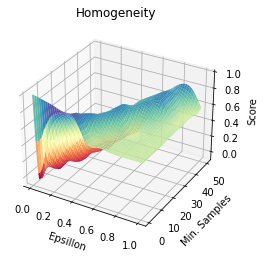

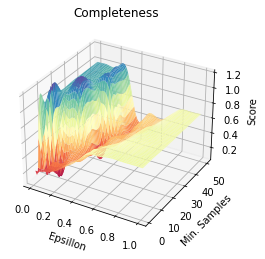

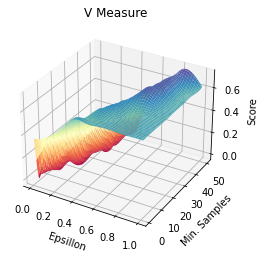

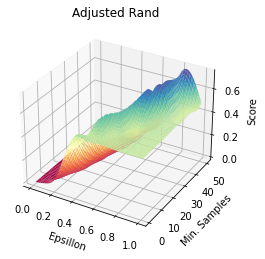

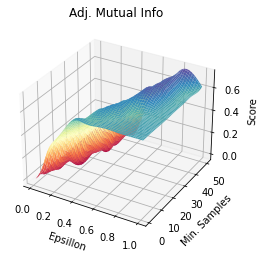

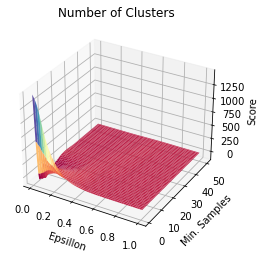

Best Epsillon =  0.9
Best N_Samples =  50.0



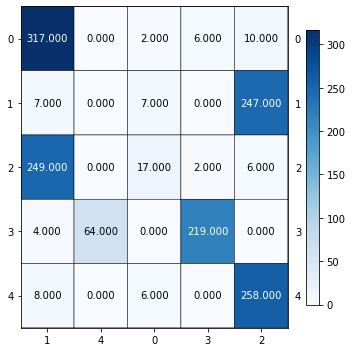

Estimated Number of Clusters:  7.0

Best DBSCAN Scores for Cosine Distance Metric
Homogeneity score:  0.7896799513244787
Completeness score:  0.667782538810624
V_measure score:  0.7236336939202158
Adjusted Rand Index score:  0.7108732847743878
Adjusted Mutual Information Score:  0.7221232251101021


In [151]:
# Find best parameter combo in DBSCAN with COSINE metric
# Generate 3D surface plots for each metric against epsillon and min samples values

umap_reducer = umap.UMAP(n_components = 5, init = 'random', metric = 'cosine', random_state=0)
bbc_umap_COS = umap_reducer.fit_transform(bbc_X_tfidf)

eps_vals = [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
samples = [1,3,5,10,20,30,35,40,50]
metric_scores_DBSCAN_COS = []

for eps in eps_vals:
    for sam in samples:
        DBSCAN_clust = DBSCAN(min_samples=sam, eps=eps)
        
        DBSCAN_clust.fit(bbc_umap)
        
        labels = DBSCAN_clust.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        
        metric_scores_DBSCAN_COS.append([metrics.homogeneity_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.completeness_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.v_measure_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.adjusted_rand_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.adjusted_mutual_info_score(bbc.target, DBSCAN_clust.labels_),
                                     n_clusters_,eps,sam])
    

# Visualize parameter effects on metrics
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
metricdata = np.array(metric_scores_DBSCAN_COS)
metric_scores = ['Homogeneity', 'Completeness', 'V Measure', 'Adjusted Rand', 'Adj. Mutual Info', 'Number of Clusters']

for i in range(0,6):
    plotdata = metricdata[:, [i,6,7]]
    z, x, y = zip(*plotdata)
    z = list(map(float, z))
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
    ax.set_xlabel('Epsillon')
    ax.set_ylabel('Min. Samples')
    ax.set_zlabel('Score')
    ax.set_title(str(metric_scores[i]))
    plt.show()

# Find best parameter combination for epsillon and minimum samples

avs = []
for i in range(len(metricdata)):
    a = ((metricdata[i][0]+metricdata[i][1]+metricdata[i][2]+metricdata[i][3]+metricdata[i][4])/5)
    avs.append(a)

b = avs.index(max(avs))
print('Best Epsillon = ', metricdata[b][6])
print('Best N_Samples = ', metricdata[b][7])
print()
cm = contingency_matrix(bbc.target, DBSCAN_clust.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(5,5))
print("Estimated Number of Clusters: ", metricdata[b][5])
print()
print("Best DBSCAN Scores for Cosine Distance Metric")
print("Homogeneity score: ", metricdata[b][0])
print("Completeness score: ", metricdata[b][1])
print("V_measure score: ", metricdata[b][2])
print("Adjusted Rand Index score: ", metricdata[b][3])
print("Adjusted Mutual Information Score: ", metricdata[b][4])




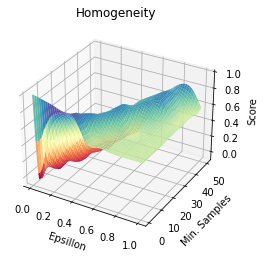

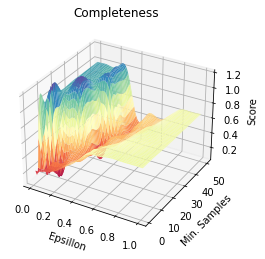

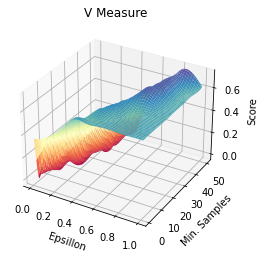

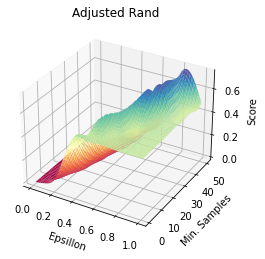

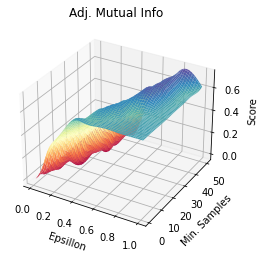

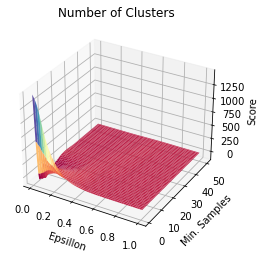

Best Epsillon =  0.9
Best N_Samples =  50.0



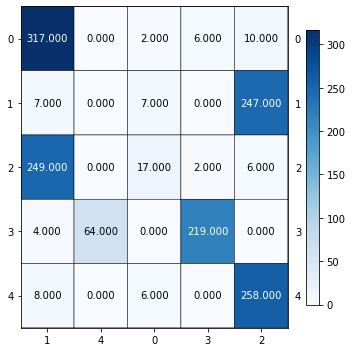

Estimated Number of Clusters:  7.0

Best DBSCAN Scores for Euclidean Distance Metric
Homogeneity score:  0.7896799513244787
Completeness score:  0.667782538810624
V_measure score:  0.7236336939202158
Adjusted Rand Index score:  0.7108732847743878
Adjusted Mutual Information Score:  0.7221232251101021


In [152]:
# Find best parameter combo in DBSCAN with EUCLIDEAN metric
# Generate 3D surface plots for each metric against epsillon and min samples values

umap_reducer = umap.UMAP(n_components = 5, init = 'random', metric = 'euclidean', random_state=0)
bbc_umap_EUC = umap_reducer.fit_transform(bbc_X_tfidf)

eps_vals = [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
samples = [1,3,5,10,20,30,35,40,50]
metric_scores_DBSCAN_EUC = []

for eps in eps_vals:
    for sam in samples:
        DBSCAN_clust = DBSCAN(min_samples=sam, eps=eps)
        
        DBSCAN_clust.fit(bbc_umap)
        
        labels = DBSCAN_clust.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        
        metric_scores_DBSCAN_EUC.append([metrics.homogeneity_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.completeness_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.v_measure_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.adjusted_rand_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.adjusted_mutual_info_score(bbc.target, DBSCAN_clust.labels_),
                                     n_clusters_,eps,sam])
    

# Visualize parameter effects on metrics
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
metricdata = np.array(metric_scores_DBSCAN_EUC)
metric_scores = ['Homogeneity', 'Completeness', 'V Measure', 'Adjusted Rand', 'Adj. Mutual Info', 'Number of Clusters']

for i in range(0,6):
    plotdata = metricdata[:, [i,6,7]]
    z, x, y = zip(*plotdata)
    z = list(map(float, z))
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
    ax.set_xlabel('Epsillon')
    ax.set_ylabel('Min. Samples')
    ax.set_zlabel('Score')
    ax.set_title(str(metric_scores[i]))
    plt.show()

# Find best parameter combination for epsillon and minimum samples

avs = []
for i in range(len(metricdata)):
    a = ((metricdata[i][0]+metricdata[i][1]+metricdata[i][2]+metricdata[i][3]+metricdata[i][4])/5)
    avs.append(a)

b = avs.index(max(avs))
print('Best Epsillon = ', metricdata[b][6])
print('Best N_Samples = ', metricdata[b][7])
print()
cm = contingency_matrix(bbc.target, DBSCAN_clust.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(5,5))
print("Estimated Number of Clusters: ", metricdata[b][5])
print()
print("Best DBSCAN Scores for Euclidean Distance Metric")
print("Homogeneity score: ", metricdata[b][0])
print("Completeness score: ", metricdata[b][1])
print("V_measure score: ", metricdata[b][2])
print("Adjusted Rand Index score: ", metricdata[b][3])
print("Adjusted Mutual Information Score: ", metricdata[b][4])
